In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pymc
import numpy as np
from scipy.stats import bernoulli

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
mu_0, sigma_0 = 0, 2
scale_0, shape_0 = 5, 5

mu_real = pymc.Normal('mu_real', mu_0, sigma_0)
sigma_real = pymc.InverseGamma('sigma_real', shape_0, scale_0)
V_real = pymc.Normal('V_real', mu_real, sigma_real, size=1000)
W_real = pymc.Normal('W_real', mu_real, sigma_real, size=1000)

@pymc.deterministic
def S_real(V=V_real, W=W_real):
    d = np.array(V > W, dtype=int)
    return d


def I_logp(value, S, p):
    diff = np.array(value == S, dtype=int)
    pp = (1 - p) * diff + p * (1 - diff)
    return sum(np.log(pp))

def I_random(S, p):
    b = bernoulli.rvs(p, size=S.shape[0])
    value = (S + p) % 2
    return value


flip_real = pymc.Stochastic( logp = I_logp,
                doc = 'Flip the observed value with probability p.',
                name = 'flip_real',
                parents = {'S': S_real, 'p': 0.01},
                random = I_random,
                trace = True,
                dtype=int,
                rseed = 1.,
                observed = False,
                plot=True,
                verbose = 0)

In [4]:
W_real.children

{<pymc.PyMCObjects.Deterministic 'S_real' at 0x10d036710>}

In [5]:
print mu_real.value
print sigma_real.value
print S_real.value[:10]
print flip_real.value[:10]

-0.402726551197
0.652299284311
[1 1 0 0 1 1 0 1 1 1]
[1 1 0 0 1 1 0 1 1 1]


In [6]:
mu = pymc.Normal('mu', mu_0, sigma_0, value=mu_real.value + 10)
sigma = pymc.InverseGamma('sigma', shape_0, scale_0, value=sigma_real.value)
V = pymc.Normal('V', mu, sigma, value=V_real.value, observed=True, size=1000)
W = pymc.Normal('W', mu, sigma, size=1000)

@pymc.deterministic
def S(V=V, W=W):
    d = np.array(V > W, dtype=int)
    return d


flip = pymc.Stochastic( logp = I_logp,
                doc = 'Flip the observed value with probability p.',
                name = 'flip',
                parents = {'S': S, 'p': 0.01},
                random = I_random,
                value = flip_real.value,
                trace = True,
                dtype = int,
                rseed = 1.,
                observed = True,
                plot = True,
                verbose = 0)

In [7]:
print W.children
print W.extended_children

set([<pymc.PyMCObjects.Deterministic 'S' at 0x10d054bd0>])
set([<pymc.PyMCObjects.Stochastic 'flip' at 0x10d054b50>])


In [8]:
model = pymc.Model([mu, sigma, V, W, flip])

In [9]:
print mu_real.value, sigma_real.value
print mu.value, sigma.value

-0.402726551197 0.652299284311
9.5972734488 0.652299284311


In [18]:
mcmc = pymc.MCMC(model)
mcmc.sample(100000, burn=0, thin=10)

 [-----------------100%-----------------] 100000 of 100000 complete in 22.1 sec

In [19]:
print mu_real.value, sigma_real.value
print mu.value, sigma.value

-0.402726551197 0.652299284311
-0.34106608939 0.881282647099


In [20]:
mu_samples = mcmc.trace('mu')[:]
# sigma_samples = mcmc.trace('sigma')[:]

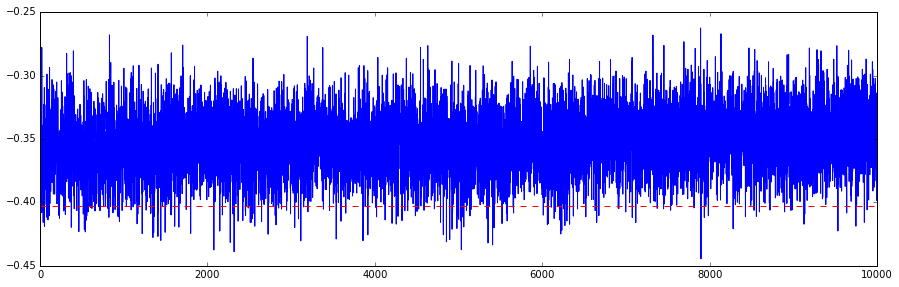

In [21]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(mu_samples)
plt.axhline(mu_real.value, color='r', linestyle='--')

# plt.subplot(2, 1, 2)
# plt.plot(sigma_samples)
# plt.axhline(sigma_real.value, color='r', linestyle='--')

In [46]:
mcmc.markov_blanket

{<pymc.distributions.InverseGamma 'sigma' at 0x114063190>: {<pymc.distributions.Normal 'W' at 0x114063d90>,
  <pymc.distributions.Normal 'V' at 0x114063cd0>,
  <pymc.distributions.InverseGamma 'sigma' at 0x114063190>,
  <pymc.distributions.Normal 'mu' at 0x113e51a90>},
 <pymc.distributions.Normal 'mu' at 0x113e51a90>: {<pymc.distributions.Normal 'W' at 0x114063d90>,
  <pymc.distributions.Normal 'V' at 0x114063cd0>,
  <pymc.distributions.InverseGamma 'sigma' at 0x114063190>,
  <pymc.distributions.Normal 'mu' at 0x113e51a90>},
 <pymc.distributions.Normal 'W' at 0x114063d90>: {<pymc.distributions.Normal 'V' at 0x114063cd0>,
  <pymc.distributions.Normal 'mu' at 0x113e51a90>,
  <pymc.distributions.Normal 'W' at 0x114063d90>,
  <pymc.distributions.InverseGamma 'sigma' at 0x114063190>,
  <pymc.PyMCObjects.Stochastic 'flip' at 0x113e89c10>}}

In [47]:
mcmc.step_method_dict

{<pymc.distributions.InverseGamma 'sigma' at 0x114063190>: [<pymc.StepMethods.Metropolis at 0x118d51ed0>],
 <pymc.distributions.Normal 'mu' at 0x113e51a90>: [<pymc.StepMethods.Metropolis at 0x118d51810>],
 <pymc.distributions.Normal 'W' at 0x114063d90>: [<pymc.StepMethods.Metropolis at 0x113dfa0d0>]}

In [48]:
s = mcmc.step_method_dict[W][0]
s

In [49]:
s.markov_blanket

[<pymc.distributions.Normal 'W' at 0x114063d90>,
 <pymc.PyMCObjects.Stochastic 'flip' at 0x113e89c10>]

In [50]:
s.children

{<pymc.PyMCObjects.Stochastic 'flip' at 0x113e89c10>}

In [51]:
W.children

{<pymc.PyMCObjects.Deterministic 'S' at 0x113e89950>,
 <pymc.PyMCObjects.Deterministic '(W_lt_sigma)' at 0x118d34350>,
 <pymc.PyMCObjects.Deterministic '(mu_lt_W)' at 0x113bbe510>,
 <pymc.PyMCObjects.Deterministic '(W_lt_V)' at 0x118d344d0>,
 <pymc.PyMCObjects.Deterministic '(mu_lt_W)' at 0x118d34b10>,
 <pymc.PyMCObjects.Deterministic '(W_lt_V)' at 0x118d34910>,
 <pymc.PyMCObjects.Deterministic '(mu_lt_W)' at 0x118d34c10>}

In [26]:
W_real.children

{<pymc.PyMCObjects.Deterministic 'S_real' at 0x10e835850>}